## 03 08 Personal Email Analytics

In [165]:
import numpy as np
import scipy.stats
import pandas as pd

In [11]:
import matplotlib
import matplotlib.pyplot as pp

import pandas.plotting

from IPython import display
from ipywidgets import interact, widgets

%matplotlib inline

In [12]:
import re
import mailbox
import csv

### Converting my mailbox.

In [57]:
mbox = mailbox.mbox('all.mbox')

The resulting object is array-like, with one entry per message. Each entry is dictionary like, with keys corresponding to metadata and data for each message.

In [58]:
mbox[0].keys()

['X-GM-THRID',
 'X-Gmail-Labels',
 'Delivered-To',
 'Received',
 'X-Google-Smtp-Source',
 'X-Received',
 'ARC-Seal',
 'ARC-Message-Signature',
 'ARC-Authentication-Results',
 'Return-Path',
 'Received',
 'Received-SPF',
 'Authentication-Results',
 'DKIM-Signature',
 'Received',
 'From',
 'To',
 'Subject',
 'Date',
 'MIME-Version',
 'Reply-To',
 'List-ID',
 'X-CSA-Complaints',
 'x-job',
 'Message-ID',
 'Feedback-ID',
 'Content-Type',
 'Content-Transfer-Encoding']

['User-Agent', 'Date', 'Subject', 'From', 'To', 'CC', 'Message-ID', 'Thread-Topic', 'References', 'In-Reply-To', 'Content-Type', 'Content-Transfer-Encoding', 'MIME-Version']

The easiest way to get these data into Pandas is to build a CSV file from them. We use the module `csv` to write out the CSV file as we loop over the mailbox object. We save only subject, from, to, and date, and we write a simple header at the top with the names of columns.

In [59]:
with open('mbox.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['subject','from','to','date'])
    
    for message in mbox:
        writer.writerow([message['subject'], message['from'], message['to'], message['date']])

All done! Thanks to Justin Ellis for inspiration with https://jellis18.github.io/post/2018-01-17-mail-analysis.

## Moving on!

In [141]:
messages = pd.read_csv('mbox-anonymized.csv')

In [142]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 4 columns):
subject    1030 non-null object
from       1029 non-null object
to         1030 non-null object
date       1030 non-null object
dtypes: object(4)
memory usage: 32.3+ KB


In [143]:
messages.head()

,subject,from,to,date
0,Why control quickly exactly capital.,"""Vallisneri, Michele (335S)"" <Michele.Vallisne...","""Trevor Charles"" <zrodriguez@hotmail.com>","Mon, 27 Nov 2017 14:18:46 -0800"
1,Work evidence from really threat sign store see.,Michele Vallisneri <Michele.Vallisneri@jpl.nas...,"""Heather Hernandez"" <patriciagarcia@garcia-car...","Mon, 26 Mar 2018 18:38:16 -0700"
2,Lot where answer the law person.,"""Vallisneri, Michele (335S)"" <michele.vallisne...",Bryce Dudley <hailey63@frazier.com>,"Tue, 13 Feb 2018 22:54:50 +0000"
3,Difference hotel yard.,"""Vallisneri, Michele (335S)"" <Michele.Vallisne...",Kathryn Mathis <josephrebecca@grimes.com>,"Fri, 26 Jan 2018 11:40:04 -0800"
4,Long level mission energy candidate.,"""Vallisneri, Michele (335S)"" <michele.vallisne...","""Angela Mendoza"" <rkhan@yahoo.com>","Tue, 31 Oct 2017 00:13:00 +0000"


simplified the email by keeping only the first recipient of each email.

### Normalize the email address
use regulation expressions

In [144]:
messages['from'][0]

'"Vallisneri, Michele (335S)" <Michele.Vallisneri@jpl.nasa.gov>'

https://docs.python.org/3/howto/regex.html

In [145]:
# use model re, grabs just the email
re.search('<(.+)>',messages['from'][0])

<_sre.SRE_Match object; span=(29, 62), match='<Michele.Vallisneri@jpl.nasa.gov>'>

In [146]:
re.search('<(.+)>',messages['from'][0]).group(0)
# group(0) will contain the entire matched expression

'<Michele.Vallisneri@jpl.nasa.gov>'

In [147]:
re.search('<(.+)>',messages['from'][0]).group(1)
# group(1) just part in parenthesis

'Michele.Vallisneri@jpl.nasa.gov'

In [148]:
re.search('<(.+)>','Michele.Vallisneri@jpl.nasa.gov').group(1)
# a different string such as just the email will not be matched.

AttributeError: 'NoneType' object has no attribute 'group'

In [149]:
# write a simple function to clean an email address
def clean_address(raw):
    match = re.search('<(.+)>',raw)
    
    if match is None:
        return raw
    else:
        return match.group(1)

In [150]:
clean_address(messages['from'][0])

'Michele.Vallisneri@jpl.nasa.gov'

In [151]:
messages['from'] = messages['from'].apply(clean_address)

TypeError: expected string or bytes-like object

In [155]:
%debug
# missing data exist in the dataframe

> /Users/lipengyuan/anaconda3/lib/python3.6/re.py(182)search()
    180     """Scan through string looking for a match to the pattern, returning
    181     a match object, or None if no match was found."""
--> 182     return _compile(pattern, flags).search(string)
    183 
    184 def sub(pattern, repl, string, count=0, flags=0):

ipdb> up
> <ipython-input-149-9302a76af737>(3)clean_address()
      1 # write a simple function to clean an email address
      2 def clean_address(raw):
----> 3     match = re.search('<(.+)>',raw)
      4 
      5     if match is None:

ipdb> print(raw)
nan
ipdb> q


In [156]:
messages['from'] = messages['from'].dropna().apply(clean_address)
messages['to'] = messages['to'].dropna().apply(clean_address)

In [157]:
messages.head()

,subject,from,to,date
0,Why control quickly exactly capital.,Michele.Vallisneri@jpl.nasa.gov,zrodriguez@hotmail.com,"Mon, 27 Nov 2017 14:18:46 -0800"
1,Work evidence from really threat sign store see.,Michele.Vallisneri@jpl.nasa.gov,patriciagarcia@garcia-carney.com,"Mon, 26 Mar 2018 18:38:16 -0700"
2,Lot where answer the law person.,michele.vallisneri@jpl.nasa.gov,hailey63@frazier.com,"Tue, 13 Feb 2018 22:54:50 +0000"
3,Difference hotel yard.,Michele.Vallisneri@jpl.nasa.gov,josephrebecca@grimes.com,"Fri, 26 Jan 2018 11:40:04 -0800"
4,Long level mission energy candidate.,michele.vallisneri@jpl.nasa.gov,rkhan@yahoo.com,"Tue, 31 Oct 2017 00:13:00 +0000"


In [158]:
messages['date'][223]

'Wed, 18 Oct 2017 22:03:53 +0000'

turn date to pandas datetime from string

In [159]:
# convert the time to my timezone
pd.to_datetime(messages['date'][223]).tz_localize('UTC').tz_convert('America/New_York')

Timestamp('2017-10-18 18:03:53-0400', tz='America/New_York')

In [160]:
messages['date'] = messages['date'].dropna().apply(lambda s: pd.to_datetime(s).tz_localize('UTC').tz_convert('America/New_York'))

In [162]:
messages.date.head()

0   2017-11-27 17:18:46-05:00
1   2018-03-26 21:38:16-04:00
2   2018-02-13 17:54:50-05:00
3   2018-01-26 14:40:04-05:00
4   2017-10-30 20:13:00-04:00
Name: date, dtype: datetime64[ns, America/New_York]

In [163]:
messages.date.min(), messages.date.max()

(Timestamp('2017-07-01 02:26:52-0400', tz='America/New_York'),
 Timestamp('2018-05-13 11:40:20-0400', tz='America/New_York'))

In [164]:
# access daytime methods in pandas by dt
messages.date.dt.weekday_name.head()

0     Monday
1     Monday
2    Tuesday
3     Friday
4     Monday
Name: date, dtype: object

### The day of week is a good example for pandas categorical variables

In [41]:
messages['dayofweek'] = pd.Categorical(messages['date'].dt.weekday_name,
                                       ordered=True,
                                       categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

In [42]:
messages['timeofday'] = messages['date'].dt.hour + messages['date'].dt.minute / 60

In [44]:
messages['nyear'] = messages['date'].dt.year + messages['date'].dt.dayofyear/365.25 + messages['timeofday']/24/365.25 

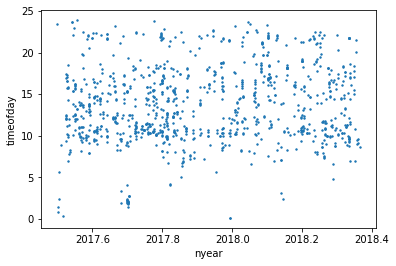

In [49]:
messages.plot.scatter('nyear','timeofday',s=2)

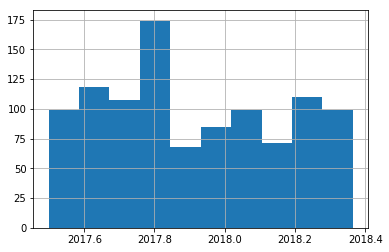

In [50]:
messages.nyear.hist()

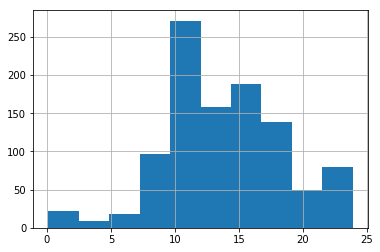

In [34]:
messages.timeofday.hist()

In [51]:
messages.dayofweek.value_counts()

Monday       222
Tuesday      220
Wednesday    211
Thursday     172
Friday       140
Sunday        33
Saturday      32
Name: dayofweek, dtype: int64

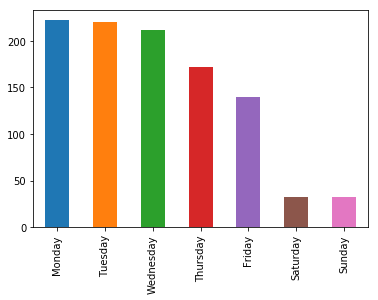

In [56]:
counts = messages.dayofweek.value_counts(sort = False)
counts.plot(kind='bar')